# Using Natural Language Processing and Sentiment Analysis to Analyze Disneyland Reviews

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from string import punctuation
from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif

from sklearn import svm
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from nltk.tokenize import word_tokenize
%matplotlib inline

In [2]:
df= pd.read_csv('DisneylandReviews.csv',index_col=0, encoding='latin1')

In [3]:
df.head(10)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
Review_ID,,,,,
670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong


In [4]:
df['Branch'].value_counts()

Disneyland_California    19406
Disneyland_Paris         13630
Disneyland_HongKong       9620
Name: Branch, dtype: int64

In [5]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [6]:
produce_missing_report(df)

,column_name,percent_missing
Rating,Rating,0.0
Year_Month,Year_Month,0.0
Reviewer_Location,Reviewer_Location,0.0
Review_Text,Review_Text,0.0
Branch,Branch,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42656 entries, 670772142 to 1536786
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rating             42656 non-null  int64 
 1   Year_Month         42656 non-null  object
 2   Reviewer_Location  42656 non-null  object
 3   Review_Text        42656 non-null  object
 4   Branch             42656 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [8]:
df = df[df['Rating'] !=3] #returns a boolean series
y_map = {1:0, 2:0, 4:1, 5:1} #scores 1-5 without 3, replace positive with 1, negative with 0
y = df['Rating'].map(y_map)
df['sentiment']=y

In [9]:
df.head(10)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment
Review_ID,,,,,,
670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1
670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1
670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1
670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1
670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1
670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,1
670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0
670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,1
670443403,5,2019-4,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,1


In [10]:
def clean_text(words):
    tokens=words.split(" ") #split string reviews into words

    tokens = [w.lower() for w in tokens]    #convert to lowercase

    table = str.maketrans('', '', string.punctuation)   #remove punctuation from each word
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]   #remove tokens that are not alphabetic

    fin=""  #convert back to string
    for word in words:
        fin+=word + " "

    return fin

    

In [11]:
df['review_contents_clean']=df['Review_Text'].apply(clean_text)

### Reasoning for cleaning Review_Text
split() was used to split the review string into words, to facilitate data cleaning

The words were converted to lowercase. This helps with classification because it allows the same words to be recognized and treated as such i.e., 'Great' and 'great' will both be treated as 'great'. This imporves accuracy

Punctuation was removed because it does not add useful information on the sentiment of the text

Words that were not aplabetic were removed because they do not contribute much to the sentiment of the text and will not help with classification


# Text Classification

In [12]:
df.head(10)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment,review_contents_clean
Review_ID,,,,,,,
670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,1,if youve ever been to disneyland anywhere youl...
670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,1,its been a while since d last time we visit hk...
670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,1,thanks god it wasn t too hot or too humid when...
670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,1,hk disneyland is a great compact park unfortun...
670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,1,the location is not in the city took around ho...
670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong,1,great place your day will go by and you wont e...
670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong,0,feel so let down with this placethe disneyland...
670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong,1,i can go on talking about disneyland whatever ...
670443403,5,2019-4,United States,Disneyland never cease to amaze me! I've been ...,Disneyland_HongKong,1,disneyland never cease to amaze me ive been to...


In [13]:
X = df['review_contents_clean']

In [14]:
X.head(5)

Review_ID
670772142    if youve ever been to disneyland anywhere youl...
670682799    its been a while since d last time we visit hk...
670623270    thanks god it wasn t too hot or too humid when...
670607911    hk disneyland is a great compact park unfortun...
670607296    the location is not in the city took around ho...
Name: review_contents_clean, dtype: object

In [15]:
y.head(5)

Review_ID
670772142    1
670682799    1
670623270    1
670607911    1
670607296    1
Name: Rating, dtype: int64

F1 score will be used to assess the performance of the classifier because it is the harmonic mean of the precission and recall scores. 
Using the precision or recall scores may result in skewed false positives of false negatives sice they are inversely related and improving one will lower the sore of the other. Therefore precision score and recall score will not be used.
Accuracy score will not be used because it only takes into consideration number of correct predictions and is not sutable for imbalanced datasets

In [16]:
def text_fit(X, y, model, clf_model): #clf_model=classification model
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test,y_pred) #TP/(TP+FP) *True Positive, False Positive
    print ('Model F1-Score: {}'.format(score))
    return (score)

In [17]:
f1_scores=[]
models=["Logistic Regression Model on word count", "Logistic Regression Model on TDIF", "Logistic Regression Model on TDIF + ngrams", "Support Vector Machine Model on word count", "Support Vector Machine Model on TDIF", "Support Vector Machine Model on TDIF + ngrams"]

#### Logistic Regression Model on word count

In [18]:
c = CountVectorizer(stop_words = 'english')
score=text_fit(X, y, c, LogisticRegression())
f1_scores.append(score)

# features: 61331
# train records: 28160
# test records: 9387
Model F1-Score: 0.9737117599162498


c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Logistic Regression Model on TDIF

In [19]:
tfidf = TfidfVectorizer(stop_words = 'english')
score= text_fit(X, y, tfidf, LogisticRegression())
f1_scores.append(score)

# features: 61331
# train records: 28160
# test records: 9387
Model F1-Score: 0.9710186513629842


#### Logistic Regression Model of TDIF + ngram

In [20]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english') 
score=text_fit(X, y, tfidf_n, LogisticRegression())
f1_scores.append(score)

# features: 898141
# train records: 28160
# test records: 9387
Model F1-Score: 0.9619580577694873


#### Support Vector Machine Model on word count

In [21]:
c = CountVectorizer(stop_words = 'english')
score=text_fit(X, y, c, svm.SVC())
f1_scores.append(score)

# features: 61331
# train records: 28160
# test records: 9387
Model F1-Score: 0.9669100867183935


#### Support Vector Machine Model on TDIF

In [22]:
tfidf = TfidfVectorizer(stop_words = 'english')
score=text_fit(X, y, tfidf, svm.SVC())
f1_scores.append(score)

# features: 61331
# train records: 28160
# test records: 9387
Model F1-Score: 0.972198238646175


#### Support Vector Machine Model on TDIF + ngram

In [23]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english') 
score=text_fit(X, y, tfidf_n, svm.SVC())
f1_scores.append(score)

# features: 898141
# train records: 28160
# test records: 9387
Model F1-Score: 0.9641682730468307


In [24]:
data={'F1-Score': f1_scores, 'Model': models}
models_df= pd.DataFrame(data)
models_df

,F1-Score,Model
0,0.973712,Logistic Regression Model on word count
1,0.971019,Logistic Regression Model on TDIF
2,0.961958,Logistic Regression Model on TDIF + ngrams
3,0.966910,Support Vector Machine Model on word count
4,0.972198,Support Vector Machine Model on TDIF
5,0.964168,Support Vector Machine Model on TDIF + ngrams


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Logistic Regression Model on word count'),
  Text(1, 0, 'Logistic Regression Model on TDIF'),
  Text(2, 0, 'Logistic Regression Model on TDIF + ngrams'),
  Text(3, 0, 'Support Vector Machine Model on word count'),
  Text(4, 0, 'Support Vector Machine Model on TDIF'),
  Text(5, 0, 'Support Vector Machine Model on TDIF + ngrams')])

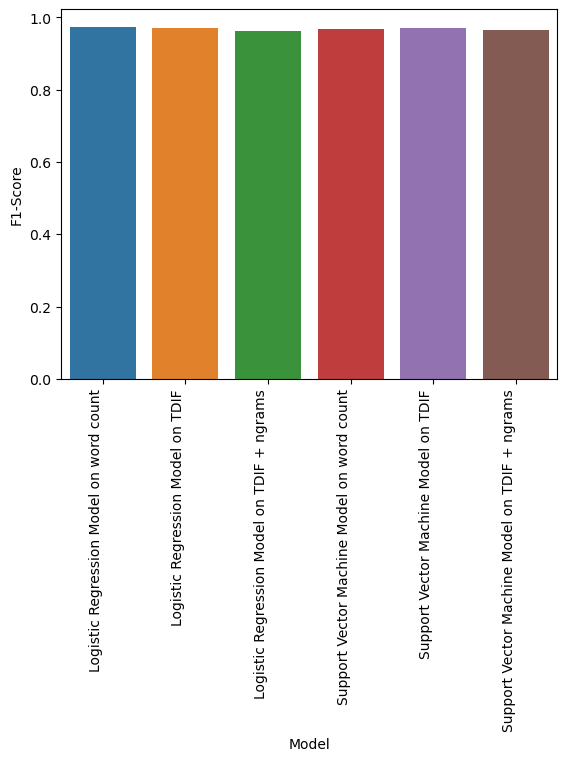

In [25]:
sns.barplot(x = 'Model',
            y = 'F1-Score',
            data = models_df)
plt.xticks(rotation=90, ha='right')

# Topic Modeling

In [26]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print("\n")

In [27]:
documents = list(X)[0:10000]
print(len(documents))

10000


In [28]:
no_topics = 5

# Using 5 topics

#### Topic Modelling with NMF

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [30]:
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [31]:
no_top_words = 10
no_top_documents = 4
print("NMF Topics \n\n")
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

NMF Topics 


Topic 0:
park rides time ride disneyland day food long went pass


we had our first real family vacation in disneyland and it was amazing things to expect long entrance lines some people find this frustrating but the lines do move fairly quickly and they are checking everyone for your own safety we recommend hats sunscreen and water bottles during your time both in line and in the park they dont allow selfie sticks we lost because we had to surrender ours they did allow go pro sticks though which didnt seem fair considering they are virtually the same thing long ride lines get the max pass on your phone for fast passes it makes all the difference for those rides in high demand you can be in line for over an hour during peak times also find out which are the rides you want to hit that are most in demand and secure a fast pass for your magic morning if you get one with your park pass or hotel stay saves you time for sure crowds it sort of goes without saying but disney sees

#### Topic Modelling with LDA

#### Topic Modelling with LDA

In [32]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()

In [33]:
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [34]:
print("\n\nLDA Topics \n\n")
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)



LDA Topics 


Topic 0:
guardians springs complain fault galaxy cake radiator miles racers soaring


this was a three generational vaca of pure fun something for all of us to enjoy and all of us enjoyed it together 


as a child in the i was brought up with walt disney his christmas message was always awaited on tv with complete silence nothing like the queens speech so disney parks from los angeles through florida to paris have been well frequented by ourmore 


unfortunately hk disney due to a fault in their website are still holding approx of my cash debit card weeks after i attempted to purchase tickets and the website kept advising me my card could not be authorised extremely poor unhelpful service from hk disney staff during my attempts to rectify this situation no disney magic in this experience 


great experience for first timers must try rides include grizzly gulch and the nightmare experiments very good actors in the nightmare experiments different creepy sensation due to i

#### Topic Modelling with SVD

In [35]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_

In [36]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_

In [37]:
print("\n\nLSI Topics \n\n")
display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



LSI Topics 


Topic 0:
park disney disneyland day rides time ride kids just food


so we ve returned from our trip to the usa and the west coast a trip that ended with a five day visit to disneyland in anaheimfor the benefit of those of you who have only ever made the journey to walt disney world near orlando is a trip to disneyland worth it or can you get much of the same experiences in central floridafirstly disneyland is made up of only two theme parks one of which disney california adventure had a troubled and frustrating gestation before finally getting itself on track only in recent years disney s keystone in california is disneyland itself the original park that took elements from existing american theme parks and pleasure gardens and perfectly fused them together into the definitive family entertainment destinationwalt disney world in florida was an effort to break free of the historic limitations of the california site and over the years has expanded to a total of four parks

| --- | Topic 1 | Topic 2 | Topic 3 | Topic 4 | Topic 5 |
| --- | --- | --- | --- | --- | --- |
| NMF | park rides time ride disneyland day food long went pass | kong hong disneyland visit visited smaller paris tokyo anaheim visiting | place kids visit enjoy disneyland love family fun parade nice | disney park world parks small smaller hk like florida land | great day fun rides family lots kids spend shows spent |
| LDA | guardians springs complain fault galaxy cake radiator miles racers soaring | park disney disneyland day rides time great food hong kong | rides disneyland ride time day place parade disney fireworks kids | rides disneyland ride time day place parade disney fireworks kids | indiana jones universal studios pushing singapore frontierland elsa monorail orleans |
| SVD | park disney disneyland day rides time ride kids just food | disneyland hong kong place visit hk kids fun parade mickey | disney park hong kong disneyland parks world hk visit florida | park disneyland pass hong kong fast theme visit line california | time ride rides like just fast disneyland people queue line |

Topic 4 is not very coherent


Based on manual observation, using 5 topics is not ideal. There is too much overlapping. In particular, the words 'Hong Kong' and 'rides' were in more than one topic. Therefore the number of topics will be cut down to 3

# Using 3 topics

In [38]:
no_topics = 3

#### Topic Modelling with NMF

In [39]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_
no_top_words = 10
no_top_documents = 4
print("NMF Topics \n\n")
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


NMF Topics 


Topic 0:
park disney day rides time ride great disneyland food good


we had our first real family vacation in disneyland and it was amazing things to expect long entrance lines some people find this frustrating but the lines do move fairly quickly and they are checking everyone for your own safety we recommend hats sunscreen and water bottles during your time both in line and in the park they dont allow selfie sticks we lost because we had to surrender ours they did allow go pro sticks though which didnt seem fair considering they are virtually the same thing long ride lines get the max pass on your phone for fast passes it makes all the difference for those rides in high demand you can be in line for over an hour during peak times also find out which are the rides you want to hit that are most in demand and secure a fast pass for your magic morning if you get one with your park pass or hotel stay saves you time for sure crowds it sort of goes without saying but disney s

c:\Users\lyndo\anaconda3\envs\lys_env\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


#### Topic Modelling with LDA

In [40]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_
print("\n\nLDA Topics \n\n")
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)



LDA Topics 


Topic 0:
staff people cast told said line rude security service members


the service staff manning the queue at cinderella photo taking spoil the day for my whole familyincident happened on at around directed to push my baby pram underneath the queue line then when i was trying to get under the queue linethe guy then pulled the rope quite forcefully and it hit my head which he did not even apologise but instead he shouted in a very rude mannerpls note that i do not understand cantonese and i was just following his gesturesuper bad experience manzdoesnt reflect on disney at alldoes disney encourages violences and rudeness as well as bad service and attitude 


hand dipped with thick corn batter to crispy perfection ketchup and mustard behind corn dog cart can buy corn dog separately and not with apple slices and drink 


they spit and litter everywhere also noisy tourists as local we still dont get the point of why we have disneyland the tourist trap of staff trained to

#### Topic Modelling with SVD

In [41]:
lsi_model = TruncatedSVD(n_components=no_topics, n_iter=7, random_state=42).fit(tf)
lsi_W = lsi_model.transform(tf)
lsi_H = lsi_model.components_
print("\n\nSVD Topics \n\n")
display_topics(lsi_H, lsi_W, tf_feature_names, documents, no_top_words, no_top_documents)



SVD Topics 


Topic 0:
park disney disneyland day rides time ride kids just food


so we ve returned from our trip to the usa and the west coast a trip that ended with a five day visit to disneyland in anaheimfor the benefit of those of you who have only ever made the journey to walt disney world near orlando is a trip to disneyland worth it or can you get much of the same experiences in central floridafirstly disneyland is made up of only two theme parks one of which disney california adventure had a troubled and frustrating gestation before finally getting itself on track only in recent years disney s keystone in california is disneyland itself the original park that took elements from existing american theme parks and pleasure gardens and perfectly fused them together into the definitive family entertainment destinationwalt disney world in florida was an effort to break free of the historic limitations of the california site and over the years has expanded to a total of four parks

The number of topics selected was 3. This was chosen using manual inspection to gauge the coherence of the topics. Overlapping was observerd between some topics where "Hong Kong" and "rides" were found in multiple topics, when 5 topics were used. When 3 topics were used there was still overlapping but there was less.

| --- | Topic 1 | Topic 2 | Topic 3 |
| --- | --- | --- | --- |
| NMF | park disney day rides time ride great disneyland food good | kong hong disneyland disney visit smaller visited world paris tokyo | place kids visit enjoy fun family disneyland love great parade |
| LDA | staff people cast told said line rude security service members | park disney disneyland day rides time great hong kong visit | rides time day ride disneyland parade park fireworks place kids |
| SVD | park disney disneyland day rides time ride kids just food | disneyland hong kong place visit hk kids fun parade mickey | disney park hong kong disneyland parks world hk visit florida |

Based on the top 10 words for the three topics, the topics correspond to the following catgories:
| Topic | Categories |
| --- | --- |
| Topic 1 | Food and Rides |
| Topic 2 | Hong Kong |
| Topic 3 | Parades and Children |